In [92]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import cv2
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#from src.thesis_xai_segmentation.utils.image import crop_patch_nd
#from src.thesis_xai_segmentation.utils.model import SemanticSegmentationModel, load_model_with_weights
#from src.thesis_xai_segmentation.utils.visualization import overlay_color_mask
from seggradcam.visualize_sgc import SegGradCAMplot
#from seggradcamplusplus.seggradcam import SegGradCAMplusplus, ClassRoIplusplus, PixelRoIplusplus
#from seggradcamplusplus.visualize_sgc import SegGradCAMplusplusplot
#from keras.optimizers import Adam

from seggradcam.dataloaders import Cityscapes
#from metrics import iou_coef, dice_coef, dice_loss
#from seggradcam.unet import csbd_unet, manual_unet, TrainUnet
from seggradcam.training_write import TrainingParameters, TrainingResults
from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot
from seggradcamplusplus.seggradcam import SegGradCAMplusplus, ClassRoIplusplus
from seggradcamplusplus.visualize_sgc import SegGradCAMplusplusplot

In [110]:
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/segnet')
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/unet')
model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/resnet50')
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/vgg_unet')
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/unet_random')
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/AttVggUnet')
#model = keras.models.load_model('C:/Users/jixia/cityscapes_segmentation/pretrained_models/unet')

In [111]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

In [95]:
folder_path = 'heatmaps'

In [96]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

In [97]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
#import seaborn as sns
import tensorflow as tf

In [98]:
def addColors(gg):
        im = np.zeros([gg.shape[0],gg.shape[1],3],dtype=np.uint8)
        for i in range(gg.shape[0]):
             for u in range(gg.shape[1]):
                if gg[i,u]==0:
                        im[i,u]=np.array( [7.97324365,  100.09284559, 3.3311774 ])# np.array([106.90082868, 139.99479298,  36.44992868]) #dirty-green
                if gg[i,u]==12:
                        im[i,u]= np.array([125.15370551, 128.00683271, 102.70661342]) 
                if gg[i,u]==11:
                        im[i,u]= np.array( [205.10936684, 155.91383531, 158.10853995])
                if gg[i,u]==10:
                        im[i,u]= np.array([202.89782929,  26.40039899,  61.60446492])
                if gg[i,u]==9:
                        im[i,u]= np.array([ 69.55103943,  70.40548991,  69.17557542])#road
                if gg[i,u]==8:
                        im[i,u]=np.array( [127.97324365,  63.09284559, 127.3311774 ])
       
                if gg[i,u]==7:
                        im[i,u]=np.array([ 76.50791694, 126.13882776, 172.87875815]) #sky
                if gg[i,u]==6:
                        im[i,u]=np.array( [157.75659272, 245.35283586, 155.30654771]) #road-dividers
                if gg[i,u]==4:
                        im[i,u]=np.array([ 80.53963208,   6.04446257,  71.14193837]) #buildings
                if gg[i,u]==5:
                        im[i,u]= np.array( [  3.55582649,   3.56494346, 136.37082893])#vehicles
                if gg[i,u]==3:
                        im[i,u]=np.array( [237.59908029,  39.26874128, 225.79570494])
                if gg[i,u]==2:
                        im[i,u]=np.array([  4.1605802 ,   3.27185434,   6.7030066 ])
                if gg[i,u]==1:
                        im[i,u]=np.array( [214.7472683 , 206.44713466,  33.15308545])
                #if gg[i,u]==0:
                 #       im[i,u]=np.array([0,128,0])
        return im

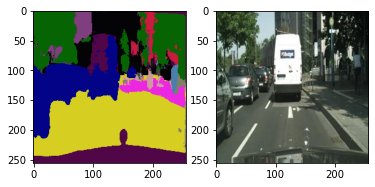

In [99]:
import cv2
m='155.jpg'
valid_folder="cityscapes_data/val"
m,tru=LoadImage(m, valid_folder)
i=np.asarray(m)
i=i.reshape((1,256,256,3))
r=model.predict(i)
r=r.reshape((256,256,-1))
s=addColors(np.argmax(r, axis=-1))
plt.subplot(1,2,1)
plt.imshow(s)
plt.subplot(1,2,2)
plt.imshow(m)


In [100]:
import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [101]:
def confusion_matrix_2(y_true, y_pred):
    N = max(max(y_true), max(y_pred)) + 1
    y = N * y_true + y_pred
    y = tf.compat.v1.bincount(y)
    if len(y) < N * N:
        y = tf.concat(y, tf.zeros(N * N - len(y)))
    y = y.reshape(N, N)
    return y

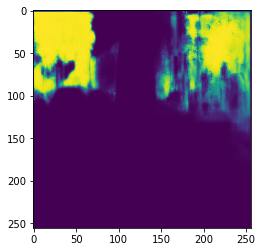

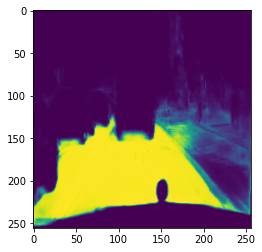

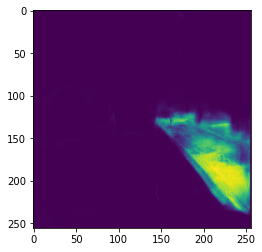

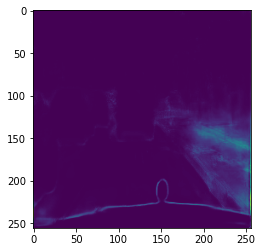

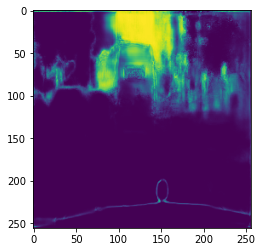

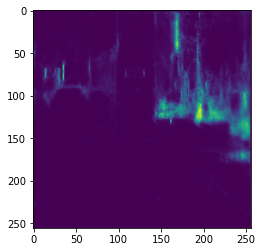

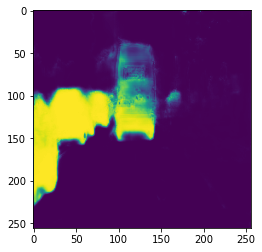

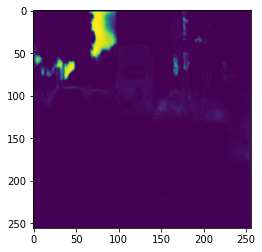

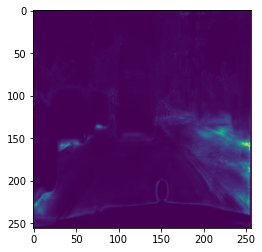

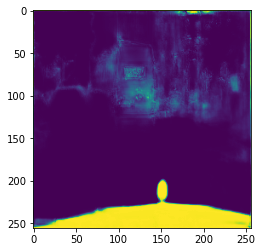

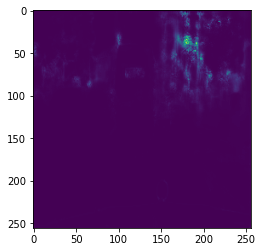

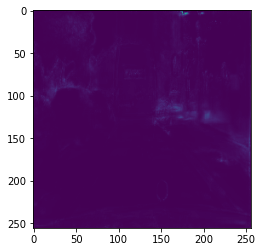

In [107]:
#rgbvar2 = [np.float32(x / 255.0) for x in m]
#rgbvar2 = np.array(rgbvar2)
#print(rgbvar2.dtype)
m = [np.float32(x) for x in m]
m = np.array(m)
img_tensor = np.expand_dims(m, 0)
output = model.predict(img_tensor)
for i in range(12):
    plt.imshow(output[:,:,:,i].squeeze())
    plt.show()

grads_3.shape (1, 128, 128, 128)
(128, 128, 128)
(128,)
aij.shape (128, 128, 128)
weights.shape: (128, 128, 128)
grads_3.shape (1, 64, 64, 256)
(64, 64, 256)
(256,)
aij.shape (64, 64, 256)
weights.shape: (64, 64, 256)
grads_3.shape (1, 32, 32, 512)
(32, 32, 512)
(512,)
aij.shape (32, 32, 512)
weights.shape: (32, 32, 512)
grads_3.shape (1, 16, 16, 1024)
(16, 16, 1024)
(1024,)
aij.shape (16, 16, 1024)
weights.shape: (16, 16, 1024)
grads_3.shape (1, 256, 256, 3)
(256, 256, 3)
(3,)
aij.shape (256, 256, 3)
weights.shape: (256, 256, 3)


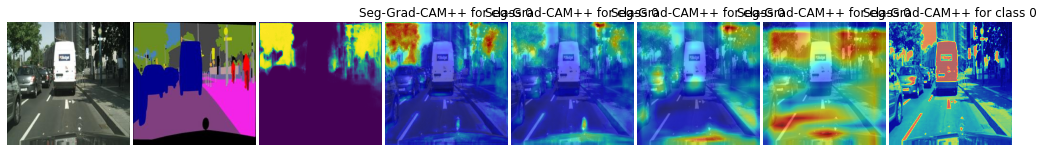

In [109]:
cls = 0
prop_from_layer = model.layers[-1].name
clsroi = ClassRoIplusplus(model, m, cls)
plt.figure(figsize=(18,18))
plt.subplot(1,8,1)
#ax.set_title("segmentation")
plt.imshow(m/255.)
plt.axis('off')
plt.subplot(1,8,2)
plt.axis('off')
plt.imshow(tru)
plt.subplot(1,8,3)
#ax.set_title("segmentation")
plt.imshow(output[:,:,:,cls].squeeze())
plt.axis('off')
plt.subplot(1,8,4)
plt.axis('off')
prop_to_layer = model.layers[-8].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,5)
plt.axis('off')
prop_to_layer = model.layers[-15].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,6)
plt.axis('off')
prop_to_layer = model.layers[-22].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,7)
plt.axis('off')
prop_to_layer = model.layers[-29].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,8)
plt.axis('off')
prop_to_layer = model.layers[0].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()
plt.subplots_adjust(wspace=0.03, hspace=0)



grads_3.shape (1, 128, 128, 64)
(128, 128, 64)
(64,)
aij.shape (128, 128, 64)
weights.shape: (128, 128, 64)
grads_3.shape (1, 64, 64, 128)
(64, 64, 128)
(128,)
aij.shape (64, 64, 128)
weights.shape: (64, 64, 128)
grads_3.shape (1, 32, 32, 256)
(32, 32, 256)
(256,)
aij.shape (32, 32, 256)
weights.shape: (32, 32, 256)
grads_3.shape (1, 16, 16, 512)
(16, 16, 512)
(512,)
aij.shape (16, 16, 512)
weights.shape: (16, 16, 512)
grads_3.shape (1, 256, 256, 3)
(256, 256, 3)
(3,)
aij.shape (256, 256, 3)
weights.shape: (256, 256, 3)


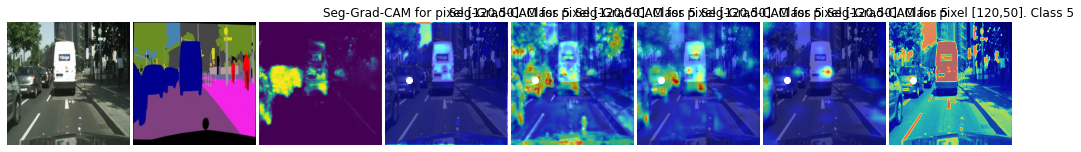

In [25]:
cls = 5
prop_from_layer = model.layers[-1].name
#roi=PixelRoI(30,20,m)#tree
roi=PixelRoI(120,50,m)#tree
clsroi = ClassRoIplusplus(model, m, cls)
plt.figure(figsize=(18,18))
plt.subplot(1,8,1)
#ax.set_title("segmentation")
plt.imshow(m/255.)
plt.axis('off')
plt.subplot(1,8,2)
plt.axis('off')
plt.imshow(tru)
plt.subplot(1,8,3)
#ax.set_title("segmentation")
plt.imshow(output[:,:,:,cls].squeeze())
plt.axis('off')
plt.subplot(1,8,4)
plt.axis('off')
prop_to_layer = model.layers[-5].name
pixsgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 
plt.subplot(1,8,5)
plt.axis('off')
prop_to_layer = model.layers[-10].name
pixsgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,6)
plt.axis('off')
prop_to_layer = model.layers[-15].name
pixsgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,7)
plt.axis('off')
prop_to_layer = model.layers[-20].name
pixsgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,8)
plt.axis('off')
prop_to_layer = model.layers[0].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 
plt.subplots_adjust(wspace=0.03, hspace=0)

<Figure size 1296x1296 with 0 Axes>

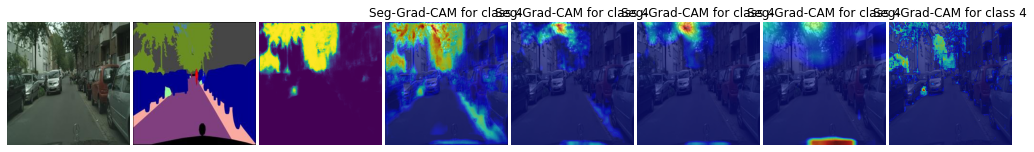

In [20]:
plt.figure(figsize=(18,18))
cls = 4
prop_from_layer = model.layers[-1].name
clsroi = ClassRoI(model, m, cls)
plt.figure(figsize=(18,18))
plt.subplot(1,8,1)
#ax.set_title("segmentation")
plt.imshow(m/255.)
plt.axis('off')
plt.subplot(1,8,2)
plt.axis('off')
plt.imshow(tru)
plt.subplot(1,8,3)
#ax.set_title("segmentation")
plt.imshow(output[:,:,:,cls].squeeze())
plt.axis('off')
plt.subplot(1,8,4)
plt.axis('off')
prop_to_layer = model.layers[-5].name
clssgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,5)
plt.axis('off')
prop_to_layer = model.layers[-10].name
clssgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,6)
plt.axis('off')
prop_to_layer = model.layers[-15].name
clssgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,7)
plt.axis('off')
prop_to_layer = model.layers[-20].name
clssgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,8)
plt.axis('off')
prop_to_layer = model.layers[0].name
clssgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()
plt.subplots_adjust(wspace=0.03, hspace=0)

grads_3.shape (1, 128, 128, 64)
(128, 128, 64)
(64,)
aij.shape (128, 128, 64)
weights.shape: (128, 128, 64)
grads_3.shape (1, 64, 64, 128)
(64, 64, 128)
(128,)
aij.shape (64, 64, 128)
weights.shape: (64, 64, 128)
grads_3.shape (1, 32, 32, 256)
(32, 32, 256)
(256,)
aij.shape (32, 32, 256)
weights.shape: (32, 32, 256)
grads_3.shape (1, 16, 16, 512)
(16, 16, 512)
(512,)
aij.shape (16, 16, 512)
weights.shape: (16, 16, 512)
grads_3.shape (1, 256, 256, 3)
(256, 256, 3)
(3,)
aij.shape (256, 256, 3)
weights.shape: (256, 256, 3)


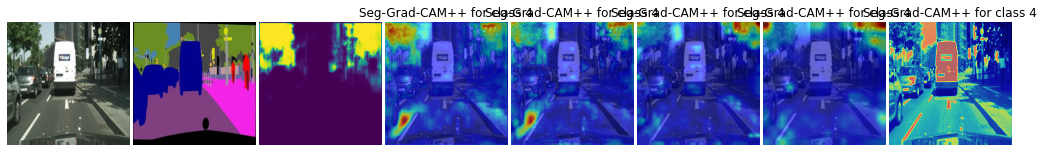

In [14]:
cls = 4
prop_from_layer = model.layers[-1].name
clsroi = ClassRoIplusplus(model, m, cls)
plt.figure(figsize=(18,18))
plt.subplot(1,8,1)
#ax.set_title("segmentation")
plt.imshow(m/255.)
plt.axis('off')
plt.subplot(1,8,2)
plt.axis('off')
plt.imshow(tru)
plt.subplot(1,8,3)
#ax.set_title("segmentation")
plt.imshow(output[:,:,:,cls].squeeze())
plt.axis('off')
plt.subplot(1,8,4)
plt.axis('off')
prop_to_layer = model.layers[-5].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,5)
plt.axis('off')
prop_to_layer = model.layers[-10].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,6)
plt.axis('off')
prop_to_layer = model.layers[-15].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,7)
plt.axis('off')
prop_to_layer = model.layers[-20].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()

plt.subplot(1,8,8)
plt.axis('off')
prop_to_layer = model.layers[0].name
clssgc = SegGradCAMplusplus(model, m, cls, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplusplusplot(clssgc, outfolder=folder_path, model=model)
clsplotter.explainClass()
plt.subplots_adjust(wspace=0.03, hspace=0)

In [ ]:
cls = 1
#roi=PixelRoI(120,50,m)#car
#roi=PixelRoI(180,90,m)#street
#roi=PixelRoI(160,150,m)#street
#roi=PixelRoI(220,50,m)#street
#roi=PixelRoI(200,180,m)#street
roi=PixelRoI(170,50,m)#street
#roi=PixelRoI(20,30,m)#tree

prop_from_layer = model.layers[-1].name
clsroi = ClassRoIplusplus(model, m, cls)
plt.figure(figsize=(18,18))
plt.subplot(1,8,1)
#ax.set_title("segmentation")
plt.imshow(m/255.)
plt.axis('off')
plt.subplot(1,8,2)
plt.axis('off')
plt.imshow(tru)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.subplot(1,8,3)
#ax.set_title("segmentation")
plt.imshow(output[:,:,:,cls].squeeze())
plt.axis('off')
plt.subplot(1,8,4)
plt.axis('off')
#segnet -10-17-24-31
#resnet -5-10-17-24
prop_to_layer = model.layers[-5].name
pixsgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 
plt.subplot(1,8,5)
plt.axis('off')
prop_to_layer = model.layers[-10].name
pixsgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,6)
plt.axis('off')
prop_to_layer = model.layers[-15].name
pixsgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,7)
plt.axis('off')
prop_to_layer = model.layers[-20].name
pixsgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 

plt.subplot(1,8,8)
plt.axis('off')
prop_to_layer = model.layers[0].name
pixsgc = SegGradCAM(model, m, cls, prop_to_layer, prop_from_layer, roi=roi, normalize=True, abs_w=False, posit_w=False)
pixsgc.SGC()
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
plotter.explainPixel() 
plt.subplots_adjust(wspace=0.03, hspace=0)

In [ ]:
#inp=plt.imread("cityscapes_data/test_frankfurt/frankfurt_000001_005898_leftImg8bit.png")
#inp = cv2.resize(inp,(256,256),interpolation = cv2.INTER_AREA)
#print(inp.shape)
#print(inp.dtype)
plt.figure(figsize=(18,18))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+(i+1))
        m="%(first)d"".jpg" % {"first": 20*i+1}
        valid_folder="cityscapes_data/val"
        m,tru=LoadImage(m, valid_folder)
        m=tf.cast(m, dtype=tf.float32)
        prop_from_layer = model.layers[-1].name
        prop_to_layer = model.layers[-5*(j+1)].name
        roi=PixelRoI(180,90,m)
        pixsgc = SegGradCAM(model, m, 6, prop_to_layer, prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
        # compute SegGradCAM
        pixsgc.SGC()
        # create an object with plotting functionality
        plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
        # plot explanations on 1 picture
        plotter.explainPixel() 

In [ ]:
plt.figure(figsize=(18,18))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+(i+1))
        m="%(first)d"".jpg" % {"first": 20*i+1}
        valid_folder="cityscapes_data/val"
        m,tru=LoadImage(m, valid_folder)
        m=tf.cast(m, dtype=tf.float32)
        prop_from_layer = model.layers[-1].name
        prop_to_layer = model.layers[-5*(j+1)].name
        roi=PixelRoI(180,90,m)
        pixsgc = SegGradCAM(model, m, 6, prop_to_layer, prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
        # compute SegGradCAM
        pixsgc.SGC()
        # create an object with plotting functionality
        plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
        # plot explanations on 1 picture
        plotter.explainPixel() 
#for i in range(4):
#    plt.subplot(4,4,(i+1))
#    m="%(first)d"".jpg" % {"first": 40*i+1}
#    valid_folder="cityscapes_data/val"
#    m,tru=LoadImage(m, valid_folder)
#    m=tf.cast(m, dtype=tf.float32)
#    prop_from_layer = model.layers[-1].name
#    prop_to_layer = model.layers[-2].name
#    roi=PixelRoI(180,90,m)
#    pixsgc = SegGradCAM(model, m, 1, prop_to_layer, prop_from_layer, roi=roi,
#                 normalize=True, abs_w=False, posit_w=False)
#    #compute SegGradCAM
#    pixsgc.SGC()
#    # create an object with plotting functionality
#    plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
#    # plot explanations on 1 picture
#    plotter.explainPixel()#

In [ ]:

prop_from_layer = model.layers[-1].name
prop_to_layer = model.layers[-3].name

roi=PixelRoI(180,90,m)
pixsgc = SegGradCAM(model, m, 1, prop_to_layer, prop_from_layer, roi=roi,
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc, outfolder=folder_path, model=model)
# plot explanations on 1 picture
plotter.explainPixel()

In [ ]:
plt.imshow(m/255.)
print(m.shape)

In [ ]:
#Plot 4 images: original, ground truth, predicted mask, seg-grad-cam explanations for a selected single pixel
plotter.pixelGtPrediction()

In [ ]:
plt.figure(figsize=(18,18))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,4*j+(i+1))
        m="%(first)d"".jpg" % {"first": 20*i+1}
        valid_folder="cityscapes_data/val"
        m,tru=LoadImage(m, valid_folder)
        m=tf.cast(m, dtype=tf.float32)
        prop_from_layer = model.layers[-1].name
        #prop_to_layer = model.layers[-5*(j+1)].name
        prop_to_layer = model.layers[-9*j-5].name
        clsroi = ClassRoI(model, m, cls = 0)
        clssgc = SegGradCAM(model, m, 0, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
        clssgc.SGC()
        clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
        clsplotter.explainClass()

#for i in range(4):
#    plt.subplot(4,4,(i+1))
#    m="%(first)d"".jpg" % {"first": 40*i+1}
#    valid_folder="cityscapes_data/val"
#    m,tru=LoadImage(m, valid_folder)
#    m=tf.cast(m, dtype=tf.float32)
#    prop_from_layer = model.layers[-1].name
#    prop_to_layer = model.layers[-2].name
#    clsroi = ClassRoI(model, m, cls = 1)
#    clssgc = SegGradCAM(model, m, 1, prop_to_layer, prop_from_layer, roi=clsroi, normalize=True, abs_w=False, posit_w=False)
#    clssgc.SGC()
#    clsplotter = SegGradCAMplot(clssgc, outfolder=folder_path, model=model)
#    clsplotter.explainClass()